### Hate Speech Detection task on Social Media(Twitter)

In [1]:
!nvidia-smi

Mon Mar 27 21:07:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --quiet transformers==4.1.1
!pip install --quiet pytorch-lightning==1.1.1
!pip install --quiet tokenizers==0.9.4
!pip install --quiet sentencepiece==0.1.94

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 58.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 669.7/669.7 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-5_vtedj_
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-5_vtedj_
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit 9b69d512d97707124e2865883397f2a1fd859c2a
  Running command git submodule update --init --recursive -q
  Encountered 31 file(s) that should have been pointers, but weren't:
        .notebooks/course_UvA-DL/01-introduction-to-pytorch.ipynb
        .notebooks/course_UvA-DL/02-activation-functions.ipynb
        .notebooks/course_UvA-DL/03-initialization-and-optimization.ipynb
        .notebooks/course_UvA-DL/04-inception-resnet-densenet.ipynb
        .notebooks/course_UvA-DL/05-transformers-and-MH-attention.ipynb
        .notebooks/course_UvA-DL/06-graph-neural-networks.ipynb
        .notebo

### GPU Set-Up

In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Import Required Libraries

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm
import time
from string import punctuation
from collections import Counter
import random
import operator

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertModel, BertTokenizer

### Data Preparations

In [6]:
from google.colab import files
uploaded = files.upload()

Saving HateSpeech.csv to HateSpeech.csv


In [7]:
import pandas as pd
import io
 
df = pd.read_csv(io.BytesIO(uploaded['HateSpeech.csv']))
print(df)

       count  hate_speech  offensive_language  neither  class  \
0          3            1                   1        2      2   
1          3            1                   1        2      2   
2          3            1                   1        2      2   
3          3            1                   1        2      2   
4          3            1                   1        2      2   
...      ...          ...                 ...      ...    ...   
50170      4            2                   1        1      0   
50171      4            2                   1        1      0   
50172      5            3                   0        2      0   
50173      4            2                   0        2      0   
50174      4            3                   1        0      0   

                                                   tweet  
0      kindly say bickering to kikuyus and kalenjins....  
1      kindly remind them that we do not have thoroug...  
2      kindly look at moses' statement. wh

### Load data

Note that I will only use two of the columns: 'tweet' and 'class' (i.e. the label). The other columns (sentiment towards Election, Hate_Speech are superfluous to the current (simple) task. 

In [8]:
def load_data(path, sample_size=5, cols=['tweet', 'class'], label=None):
    """Helper function that loads data from a given path into a pandas
       DataFrame, using only the specified cols. Also prints basic info
       about the dataset size and displays a sample of the rows. 
    """
    
    df = pd.read_csv(path, sep='\t', usecols=cols)
    
    print(f"\nThere are {df.shape[0]} tweets in the {label} dataset.")
    print("\nHere's a sample:\n")
    display(df.sample(sample_size))
    
    return df

In [9]:
# Are there any duplicates?
assert len(df['tweet'].drop_duplicates()) == len(df['tweet'])

### Quick inspection / visualisation

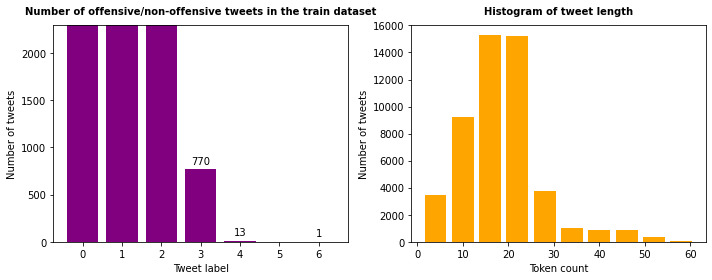

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Distribution by class
ax[0].bar(x = df['hate_speech'].unique(), # Data labels
       height = df['hate_speech'].value_counts().values, # Num of tweets in each category
       color='purple')

ax[0].bar_label(ax[0].containers[0], label_type='edge', padding=3) # Annotate bars
ax[0].set_ylim(0, 2300) # Raise upper limit of y-axis, to accommodate labels

ax[0].set_title("Number of offensive/non-offensive tweets in the train dataset", 
             fontweight='bold', fontsize=10, y = 1.02)
ax[0].set_ylabel("Number of tweets")
ax[0].set_xlabel('Tweet label')

# Distribution by length
ax[1].hist([len(tweet) for tweet in df['tweet'].apply(lambda x: x.split())], 
           color='orange', rwidth=0.8)
ax[1].set_xlabel('Token count')
ax[1].set_ylabel('Number of tweets')
ax[1].set_title("Histogram of tweet length", 
                fontweight='bold', fontsize=10, y = 1.02)


plt.tight_layout()
plt.show()

#### Deal with class imbalances

Downsample from the majority ('Non-Offensive') class.

In [11]:
print('Before downsampling: ')
print(f"Offensive: {len(df[df['hate_speech']==1])}")
print(f"Neither: {len(df[df['hate_speech']==0])}")

train_hateful = df[df['hate_speech']==1]
train_nonhateful = df[df['hate_speech']==0].sample(len(train_hateful))
train_downsampled = pd.concat([train_hateful, train_nonhateful], axis=0).sample(frac=1)

print('\nAfter downsampling: ')
print(f"Offensive: {len(train_downsampled[train_downsampled['hate_speech']==1])}")
print(f"Neither: {len(train_downsampled[train_downsampled['hate_speech']==0])}")

Before downsampling: 
Offensive: 7483
Neither: 39448

After downsampling: 
Offensive: 7483
Neither: 7483


#### Split train data set into train and development sets

To provide a way to assess the model's performance after each training loop.

In [12]:
# Split train data set into train and development sets
train, dev = train_test_split(train_downsampled, test_size=0.5, stratify=train_downsampled['hate_speech'])

Prepare data

Convert the text and labels into a format that is acceptable for the model. First, torch.utils.data.Dataset - stores the samples and their corresponding labels. We create a simple pipeline for cleaning and tokenizing the tweets. I will use the bert-base-uncased tokenizer so that the tokenizer matches the model. This is because (1) the model has a specific, fixed vocabulary, and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.torch.utils.data.DataLoader - wraps an iterable around the Dataset, enabling us to iterate through the samples. Can also be used to transform the data (if you provide a custom collate_fn).


In [13]:
# Clean the tweets' text
def clean_text(tweet):
    """A function that performs basic cleaning of a tweet's text.
    """
    
    # Replace mentions and URLs with special token
    tweet = re.sub(r"@[A-Za-z0-9_-]+",'USR',tweet)
    tweet = re.sub(r"http\S+",'URL',tweet)
    
    # Remove \n and \t characters
    tweet = tweet.replace('\n', ' ')
    tweet = tweet.replace('[NEWLINE]', ' ')
    tweet = tweet.replace('\t', ' ')
    
    # Strip whitespace
    tweet = tweet.strip()
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # return [w.strip(punctuation) for w in tweet.split() if w.strip(punctuation)!='']
    return tweet

In [14]:
# Define Dataset class which cleans, tokenizes and encodes data
class BERTDataset(Dataset):
    
    def __init__(self, data):
        
        # Initialize BERT tokenizer
        # Note that I need to specify cache_dir because I'm using a venv
        self.tok = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir=Path.cwd()/'venv/lib/python3.8/site-packages')
        
        # Clean tweets
        self.cleaned_tweets = data['tweet'].apply(lambda x: clean_text(x))
        
        # Truncate and encode tweets, up to max_length of 60
        # While this is lower than BERT's max (512), it was chosen for computational speed
        self.tweets = list(self.cleaned_tweets.apply(self.tok.encode, max_length=60, truncation=True))
        
        # Store labels
        self.labels = list(data['hate_speech'])
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        return tweet, label
    
# Inspect an example
# BD = BERTDataset(train.iloc[:5])
# next(iter(BD))

In [15]:
# Define collate function to be passed to DataLoader
def bert_collate(batch):
    
    # Store batch size
    batch_size = len(batch)
    
    # Separate tweets and labels
    tweets = [t for t, _ in batch]
    labels = torch.tensor([l for _, l in batch]).long()
    
    # Store length of longest tweet in batch
    max_len = max(len(t) for t in tweets)
    
    # Create padded tweet and attention mask tensors
    tweets_pad = torch.zeros((batch_size, max_len)).long()
    masks_pad = torch.zeros((batch_size, max_len)).long()
    for i, t in enumerate(tweets):
        tweets_pad[i, :len(t)] = torch.tensor(t)
        masks_pad[i, :len(t)] = 1
        
    return tweets_pad, masks_pad, labels

In [16]:
%%time

# Create data sets
train_dataset = BERTDataset(train)
dev_dataset = BERTDataset(dev)
test_dataset = BERTDataset(df)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

CPU times: user 33.1 s, sys: 105 ms, total: 33.2 s
Wall time: 34.3 s


In [17]:
# Create data loaders using torch.utils.data.DataLoader class
# Using shuffle=True instead of specifying RandomSampler
train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=bert_collate, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=100, collate_fn=bert_collate)
test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=bert_collate)

In [18]:
# Inspect
for (idx, batch) in enumerate(train_loader):

    print(f'\n\n--------------------- Batch {idx} ---------------------\n')
    
    # Print the text
    print(f"There are {len(batch[0])} encoded tweets in this batch.")
    print('Tweets (encoded): ', batch[0])

    # Print the label
    print(f"There are {len(batch[2])} encoded labels in this batch. Here they are: ")
    print('Labels: ', batch[2])



--------------------- Batch 0 ---------------------

There are 100 encoded tweets in this batch.
Tweets (encoded):  tensor([[  101, 24761,  2072,  ...,     0,     0,     0],
        [  101,  2001,  8534,  ...,     0,     0,     0],
        [  101,  2903,  2033,  ...,     0,     0,     0],
        ...,
        [  101, 10166,   999,  ...,     0,     0,     0],
        [  101, 11999,  2131,  ...,     0,     0,     0],
        [  101,  2017,  4440,  ...,     0,     0,     0]])
There are 100 encoded labels in this batch. Here they are: 
Labels:  tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0])


--------------------- Batch 1 ---------------------

There are 100 encoded tweets in this batch.
Tweets (enc

In [19]:
# Define BERT classifier
class BERTClassifier(nn.Module):
    
    def __init__(self):
        
        # Specify network layers
        # Note that I need to specify cache as I'm using a venv
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', cache_dir=Path.cwd()/'venv/lib/python3.8/site-packages')
        self.linear = nn.Linear(768, 4)
        
        # Define dropout
        self.dropout = nn.Dropout(0.2)
        
        # Freeze BERT layers
        for n, p in self.bert.named_parameters():
            p.requires_grad = False
            
    def forward(self, tweets, masks):
        
        # Define flow of tensors through the network
        output_bert = self.bert(tweets, attention_mask=masks)[0].mean(axis=1)
        return self.linear(self.dropout(output_bert))

### Fine-Tuning the pretrained BERT model

In [20]:
# Initialise model
model = BERTClassifier()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [21]:
# Move model to device
model = model.to(device)

In [22]:
# Define optimiser, objective function and epochs
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 10

In [23]:
%%time

# Train model
for epoch_i in range(1, epochs):
    
    # ========================================
    #               Training
    # ========================================
        
    # Put model into training mode. This is necessary so that the `Dropout`
    # layers are activated. 
    model.train()
    
    # For each batch of the training data...
    for i, batch in enumerate(tqdm(train_loader)):
        
        # Step 1. Since PyTorch accumulates gradients, clear any previously
        # calculated gradients before performing a backward pass.
        # PyTorch doesn't do this automatically because it can be useful while
        # training RNNs.
        optimizer.zero_grad()
        
        # Step 2. Extract data and move to device.
        tweets, masks, labels = [t.to(device) for t in batch]
        
        # Step 3. Forward pass - note that calling `model()` will in turn call
        # the model's `forward()` function.
        output = model(tweets, masks)
        
        # Step 4. Compute loss.
        loss = criterion(output, labels)
        
        # Step 5. Perform backward pass to calculate gradients wrt each w and b term. 
        loss.backward()
        
        # Step 6. Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Step 7. Update parameters and take a step using the computed gradient.
        optimizer.step()
        
    # ========================================
    #               Validation
    # ========================================
    
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    # Put model into evaluation mode, thereby deactivating Dropout layer.
    model.eval()
    
    y_true = list()
    y_pred = list()
    
    with torch.no_grad(): # We no longer need it to store computation graph.
        for batch in dev_loader:
            tweets, masks, labels = [t.to(device) for t in batch]
            output = model(tweets, masks)
            max_output = output.argmax(dim=1)
            y_true.extend(labels.tolist())
            y_pred.extend(max_output.tolist())
            
    print(f"Accuracy after {epoch_i} epoch(s): {accuracy_score(y_true, y_pred)}")

100%|██████████| 75/75 [00:24<00:00,  3.12it/s]


Accuracy after 1 epoch(s): 0.6923693705732995


100%|██████████| 75/75 [00:22<00:00,  3.38it/s]


Accuracy after 2 epoch(s): 0.6955766403848723


100%|██████████| 75/75 [00:23<00:00,  3.15it/s]


Accuracy after 3 epoch(s): 0.685553922223707


100%|██████████| 75/75 [00:23<00:00,  3.18it/s]


Accuracy after 4 epoch(s): 0.6744621141253508


100%|██████████| 75/75 [00:23<00:00,  3.15it/s]


Accuracy after 5 epoch(s): 0.6999866363757851


100%|██████████| 75/75 [00:23<00:00,  3.15it/s]


Accuracy after 6 epoch(s): 0.6967793665642122


100%|██████████| 75/75 [00:23<00:00,  3.15it/s]


Accuracy after 7 epoch(s): 0.6957102766270212


100%|██████████| 75/75 [00:23<00:00,  3.15it/s]


Accuracy after 8 epoch(s): 0.6792730188427102


100%|██████████| 75/75 [00:23<00:00,  3.16it/s]


Accuracy after 9 epoch(s): 0.696913002806361
CPU times: user 7min, sys: 1.04 s, total: 7min 1s
Wall time: 7min 4s


In [24]:
%%time

# ========================================
#               Evaluation
# ========================================

# Evaluate model on test data
model.eval()

y_true = list()
y_pred = list()

with torch.no_grad():
    for batch in test_loader:
        tweets, masks, labels = [t.to(device) for t in batch]
        output = model(tweets, masks)
        max_output = output.argmax(dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(max_output.tolist())

print('Test accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
print('\nClassification report: \n', classification_report(y_true, y_pred))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: hate_speech": confusion_matrix(y_true, y_pred)[:, 0], 
              "Predicted: offensive_language": confusion_matrix(y_true, y_pred)[:, 1]},
             index=['Actual: hate_speech', 'Actual: offensive_language']))

Test accuracy: 0.61

Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.63      0.75     39448
           1       0.25      0.78      0.38      7483
           2       0.00      0.00      0.00      2460
           3       0.00      0.00      0.00       770
           4       0.00      0.00      0.00        13
           6       0.00      0.00      0.00         1

    accuracy                           0.61     50175
   macro avg       0.20      0.24      0.19     50175
weighted avg       0.77      0.61      0.65     50175


Confusion matrix: 



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: ignored

### Comparison to baselines

In [25]:
# Predict all majority class
y_pred = [0] * len(df)
y_true = df['hate_speech']
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     39448
           1       0.00      0.00      0.00      7483
           2       0.00      0.00      0.00      2460
           3       0.00      0.00      0.00       770
           4       0.00      0.00      0.00        13
           6       0.00      0.00      0.00         1

    accuracy                           0.79     50175
   macro avg       0.13      0.17      0.15     50175
weighted avg       0.62      0.79      0.69     50175



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Probabilistic guess
maj_prob = df['hate_speech'].value_counts(normalize=True).values
#y_pred = [0]*int(maj_prob*len(df)) + [1]*int(maj_prob*len(df))
y_pred = random.sample(y_pred, len(y_pred))
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     39448
           1       0.00      0.00      0.00      7483
           2       0.00      0.00      0.00      2460
           3       0.00      0.00      0.00       770
           4       0.00      0.00      0.00        13
           6       0.00      0.00      0.00         1

    accuracy                           0.79     50175
   macro avg       0.13      0.17      0.15     50175
weighted avg       0.62      0.79      0.69     50175



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naïve Bayes BoW classifier

In [27]:
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Generate vocabs
n_total, vocab, distinct_mentions = get_vocabs(train)

# Generate MI list
mi_list = sorted([(mi(w, distinct_mentions, n_total), w) for w in set(vocab[1]).union(set(vocab[0]))], reverse=True)

# Estimate P(c_i), the probability of class c_i
categories = [0, 1]
prob_class = dict()
total_tweets = len(train)
for c_i in categories:
    prob_class[c_i] = len(train[train['HOF']==c_i]) / total_tweets

# Get predictions on test set using arbitrary values for n_features and smoothing_alpha
# This is just to test that it works
probs = naive_bayes_additive_smoothing_feature_selection(vocab, categories, 0.25, 1000, mi_list)
labels, predictions = get_nb_predictions(categories, test, probs, prob_class)
print(classification_report(labels, predictions))